In [3]:
import pandas as pd
import numpy as np
import random

# Sample data
data = {
    "Question No": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    "Question Full Marks": [5, 4, 3, 6, 5, 4, 3, 6, 5, 4, 3, 6, 5, 4, 3],
    "Learning Indicator ID": ["LI001", "LI002", "LI003", "LI004", "LI005", "LI006", "LI007", "LI008", "LI001", "LI002", "LI003", "LI004", "LI005", "LI006", "LI007"],
    "Learning Indicator Text": [
        "Understand basic algebraic concepts", "Apply geometric principles", "Solve linear equations", "Interpret statistical data",
        "Analyze historical events", "Understand economic theories", "Apply scientific method", "Comprehend literary texts",
        "Understand basic algebraic concepts", "Apply geometric principles", "Solve linear equations", "Interpret statistical data",
        "Analyze historical events", "Understand economic theories", "Apply scientific method"
    ]
}

# Create question DataFrame
question_df = pd.DataFrame(data)

def generate_student_data(question_df, no_of_students):
    student_data = []
    for student_id in range(1, no_of_students + 1):
        for _, row in question_df.iterrows():
            question_no = row["Question No"]
            max_marks = row["Question Full Marks"]
            marks_obtained = random.randint(0, max_marks)
            student_data.append([question_no, student_id, marks_obtained, max_marks])
    
    student_df = pd.DataFrame(student_data, columns=["Question No", "Student ID", "Marks Obtained", "Max Marks"])
    return student_df

# Example usage
no_of_students = 35
student_df = generate_student_data(question_df, no_of_students)

In [5]:
student_df.to_csv("students_df.csv",index=False)

In [44]:

question_df.columns = ["question_number","full_marks","learning_indicator_id","learning_indicator_text"]
student_df.columns = ["question_number","student_id","marks_obtained","maximum_marks"]
student_df.to_csv("students_df.csv",index=False)
question_df.to_csv("question_paper.csv",index=False)

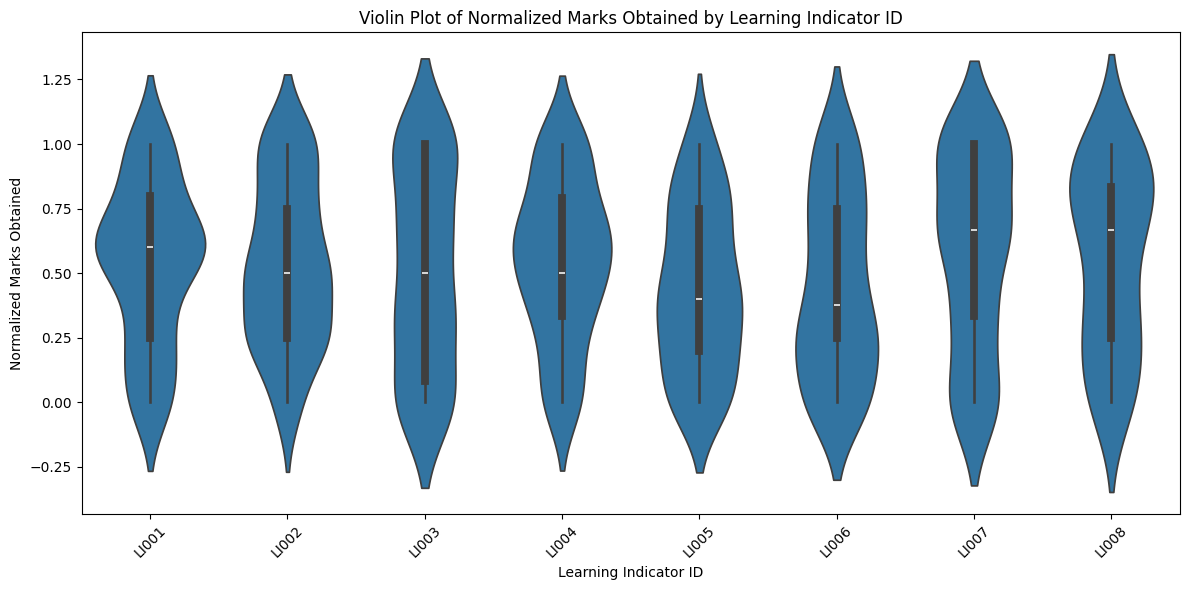

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_violin_by_li(question_data, student_performance_data):
    # Merge the dataframes on question number
    merged_data = pd.merge(student_performance_data, question_data, on='question_number')
    
    merged_data['normalized_marks'] = merged_data['marks_obtained'] / merged_data['maximum_marks']
    
    # Create the violin plot
    plt.figure(figsize=(12, 6))
    sns.violinplot(x='learning_indicator_id', y='normalized_marks', data=merged_data)
    plt.xlabel('Learning Indicator ID')
    plt.ylabel('Normalized Marks Obtained')
    plt.title('Violin Plot of Normalized Marks Obtained by Learning Indicator ID')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



plot_violin_by_li(question_df, student_df)

In [42]:
def categorize_marks(normalized_marks):
    if normalized_marks >= 0.8:
        return '80-100%'
    elif normalized_marks >= 0.6:
        return '60-80%'
    else:
        return '<60%'

def analyze_student_performance_by_li(question_data, student_performance_data):
    # Merge the dataframes on question number
    merged_data = pd.merge(student_performance_data, question_data, on='question_number')
    
    merged_data = merged_data.groupby(["student_id","learning_indicator_id"])[["marks_obtained","maximum_marks"]].sum().reset_index()
    merged_data['normalized_marks'] = merged_data['marks_obtained'] / merged_data['maximum_marks']
    # print(merged_data)
    # Categorize the normalized marks
    merged_data['category'] = merged_data['normalized_marks'].apply(categorize_marks)
    
    # Group by learning indicator ID and category, and count the number of students in each category
    merged_data = merged_data.groupby(['learning_indicator_id', 'category']).size().unstack(fill_value=0)
    
    # Rename the columns for better readability
    merged_data.columns = ['<60%', '60-80%', '80-100%']
    merged_data = merged_data.sort_values(['<60%', '60-80%', '80-100%'],ascending=[False,False,False]).reset_index()
    
    # Display the results
    return merged_data

In [45]:
category_counts=analyze_student_performance_by_li(question_df,student_df)
category_counts

learning_indicator_id  <60%  60-80%  80-100%
0                 LI002    12       4       19
1                 LI001    11       6       18
2                 LI004    10       3       22
3                 LI006    10       2       23
4                 LI005     9       2       24
5                 LI008     5      14       16
6                 LI007     4      12       19
7                 LI003     4       6       25

In [27]:
35*0.8

28.0

In [48]:

def prioritize_lis(category_counts):
    # Add a rank column based on the order of rows
    category_counts['Rank'] = category_counts.index + 1
    
    # Determine the number of LIs
    total_lis = len(category_counts)
    
    # Determine the cutoff points for high, medium, and low priority
    high_priority_cutoff = int(total_lis * 0.3)
    medium_priority_cutoff = int(total_lis * 0.6)
    
    # Classify the LIs based on their rank
    category_counts['Priority'] = 'Low'
    category_counts.loc[category_counts['Rank'] <= high_priority_cutoff, 'Priority'] = 'High'
    category_counts.loc[(category_counts['Rank'] > high_priority_cutoff) & (category_counts['Rank'] <= medium_priority_cutoff), 'Priority'] = 'Medium'
    
    return category_counts

prioritized_lis = prioritize_lis(category_counts)
print(prioritized_lis)

  learning_indicator_id  <60%  60-80%  80-100%  Rank Priority
0                 LI002    12       4       19     1     High
1                 LI001    11       6       18     2     High
2                 LI004    10       3       22     3   Medium
3                 LI006    10       2       23     4   Medium
4                 LI005     9       2       24     5      Low
5                 LI008     5      14       16     6      Low
6                 LI007     4      12       19     7      Low
7                 LI003     4       6       25     8      Low


In [55]:
def student_level_analysis(student_data, question_data, prioritized_lis):
    # Merge the student data with question data
    merged_data = pd.merge(student_data, question_data, on='question_number')
    
    # Normalize the marks obtained for each learning indicator by each student
    merged_data = merged_data.groupby(['student_id', 'learning_indicator_id'])[['marks_obtained', 'maximum_marks']].sum().reset_index()
    merged_data['normalized_marks'] = merged_data['marks_obtained'] / merged_data['maximum_marks']
    
    # Merge with prioritized_lis to get the priority and rank
    merged_data = pd.merge(merged_data, prioritized_lis[['learning_indicator_id', 'Rank']], on='learning_indicator_id', how='left')
    
    # Rank the LIs for each student based on normalized marks and class-level LI priority
    merged_data['student_rank'] = merged_data.groupby('student_id')['normalized_marks'].rank(method='dense', ascending=False)
    merged_data = merged_data.sort_values(by=['student_id', 'student_rank', 'Rank'])
    
    # Ensure unique ranks by adding a secondary sort by Rank
    merged_data['unique_rank'] = merged_data.groupby('student_id').cumcount() + 1
    
    # Create the final dataframe
    student_ranking = merged_data.pivot(index='student_id', columns='unique_rank', values='learning_indicator_id').reset_index()
    student_ranking.columns = ['student_id'] + [f'P{i+1}_li' for i in range(student_ranking.shape[1] - 1)]
    
    return student_ranking

In [56]:
student_level_analysis(student_df,question_df,prioritized_lis)

student_id  P1_li  P2_li  P3_li  P4_li  P5_li  P6_li  P7_li  P8_li
0            1  LI008  LI001  LI004  LI002  LI005  LI007  LI003  LI006
1            2  LI007  LI005  LI002  LI001  LI004  LI003  LI008  LI006
2            3  LI008  LI007  LI001  LI004  LI006  LI003  LI005  LI002
3            4  LI002  LI004  LI007  LI006  LI001  LI005  LI008  LI003
4            5  LI004  LI006  LI001  LI003  LI007  LI002  LI005  LI008
5            6  LI005  LI007  LI008  LI002  LI004  LI003  LI001  LI006
6            7  LI005  LI007  LI003  LI001  LI004  LI006  LI002  LI008
7            8  LI006  LI005  LI008  LI003  LI004  LI002  LI001  LI007
8            9  LI008  LI002  LI001  LI004  LI005  LI007  LI003  LI006
9           10  LI007  LI003  LI008  LI001  LI006  LI002  LI004  LI005
10          11  LI002  LI007  LI001  LI004  LI005  LI006  LI008  LI003
11          12  LI003  LI004  LI001  LI007  LI008  LI002  LI006  LI005
12          13  LI008  LI007  LI006  LI004  LI005  LI003  LI001  LI002
13          14  LI001  LI006  LI002  LI007  LI003  LI004  LI005  LI008
14          15  LI002  LI007  LI005  LI008  LI003  LI001  LI004  LI006
15          16  LI008  LI004  LI006  LI005  LI007  LI003  LI001  LI002
16          17  LI007  LI004  LI002  LI006  LI005  LI003  LI001  LI008
17          18  LI008  LI003  LI002  LI006  LI005  LI004  LI001  LI007
18          19  LI007  LI003  LI004  LI006  LI002  LI005  LI008  LI001
19          20  LI004  LI008  LI007  LI002  LI005  LI001  LI003  LI006
20          21  LI003  LI002  LI001  LI004  LI005  LI008  LI007  LI006
21          22  LI008  LI004  LI001  LI003  LI006  LI005  LI002  LI007
22          23  LI001  LI004  LI002  LI008  LI007  LI003  LI005  LI006
23          24  LI001  LI002  LI005  LI004  LI003  LI006  LI007  LI008
24          25  LI002  LI008  LI006  LI001  LI007  LI003  LI004  LI005
25          26  LI008  LI001  LI002  LI007  LI003  LI004  LI006  LI005
26          27  LI004  LI008  LI002  LI001  LI005  LI007  LI003  LI006
27          28  LI001  LI008  LI007  LI006  LI005  LI002  LI003  LI004
28          29  LI006  LI007  LI003  LI002  LI001  LI005  LI004  LI008
29          30  LI002  LI008  LI004  LI003  LI005  LI007  LI006  LI001
30          31  LI008  LI007  LI003  LI002  LI006  LI001  LI005  LI004
31          32  LI007  LI006  LI002  LI004  LI005  LI001  LI003  LI008
32          33  LI005  LI001  LI008  LI002  LI004  LI006  LI003  LI007
33          34  LI008  LI001  LI006  LI005  LI002  LI004  LI007  LI003
34          35  LI008  LI004  LI005  LI007  LI003  LI001  LI002  LI006

In [57]:
import pandas as pd

def prepare_data_for_ridge_plot(student_data, question_data):
    # Merge the DataFrames
    merged_data = pd.merge(student_data, question_data, on='question_number', how='inner')
    
    # Normalize the marks obtained for each learning indicator by each student
    normalized_data = merged_data.groupby(['student_id', 'learning_indicator_id'])[['marks_obtained', 'maximum_marks']].sum().reset_index()
    normalized_data['normalized_marks'] = normalized_data['marks_obtained'] / normalized_data['maximum_marks']
    
    # Add learning_indicator_text to normalized_data
    plot_data = pd.merge(normalized_data, question_data[['learning_indicator_id', 'learning_indicator_text']].drop_duplicates(), on='learning_indicator_id')
    
    return plot_data

In [177]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def prepare_data_for_ridge_plot(student_data, question_data):
    # Merge the DataFrames
    merged_data = pd.merge(student_data, question_data, on='question_number', how='inner')
    
    # Normalize the marks obtained for each learning indicator by each student
    normalized_data = merged_data.groupby(['student_id', 'learning_indicator_id'])[['marks_obtained', 'maximum_marks']].sum().reset_index()
    normalized_data['normalized_marks'] = normalized_data['marks_obtained'] / normalized_data['maximum_marks']
    
    # Add learning_indicator_text to normalized_data
    plot_data = pd.merge(normalized_data, question_data[['learning_indicator_id', 'learning_indicator_text']].drop_duplicates(), on='learning_indicator_id')
    
    return plot_data

def calculate_logical_quantiles(data, num_quantiles=5):
    """
    Calculate logical quantiles for a given data set to ensure they are informative.
    
    Parameters:
    data (array-like): The input data for which to calculate quantiles.
    num_quantiles (int): The number of quantiles to calculate. Default is 5.
    
    Returns:
    list: A list of quantile values.
    """
    # Ensure there are enough unique values to calculate the quantiles
    if len(np.unique(data)) < num_quantiles:
        # If not enough unique values, use unique values as quantiles
        quantiles = np.unique(data)
    else:
        # Calculate evenly spaced quantiles
        quantiles = np.percentile(data, np.linspace(0, 100, num_quantiles))
    
    return quantiles.tolist()

def create_ridge_plot(plot_data):
    unique_learning_indicators = plot_data['learning_indicator_text'].unique()
    n_indicators = len(unique_learning_indicators)
    bandwidth = 0.5  # Adjust bandwidth for smoother graphs
    darkgreen = '#9BC184'
    midgreen = '#C2D6A4'
    lightgreen = '#E7E5CB'
    colors = [lightgreen, midgreen, darkgreen, midgreen, lightgreen]

    fig, axs = plt.subplots(nrows=n_indicators, ncols=1, figsize=(10, n_indicators * 1.5), sharex=True)
    axs = axs.flatten()  # Flatten in case of single plot

    for i, indicator in enumerate(unique_learning_indicators):
        # Subset the data for each learning indicator
        subset = plot_data[plot_data['learning_indicator_text'] == indicator]

        # Plot the distribution of normalized marks
        sns.kdeplot(
            subset['normalized_marks'],
            shade=True,
            bw_adjust=bandwidth,
            ax=axs[i],
            color=sns.color_palette('coolwarm', n_colors=n_indicators)[i]
        )
        quantiles = calculate_logical_quantiles(subset["normalized_marks"].tolist())

        # fill space between each pair of quantiles
        for j in range(len(quantiles) - 1):
            axs[i].fill_between(
                [quantiles[j], # lower bound
                quantiles[j+1]], # upper bound
                0.1, # max y=0
                0.3, # max y=0.0002
                color=colors[j]
            )
        mean = subset['marks_obtained'].sum()/subset['maximum_marks'].sum()
        axs[i].scatter([mean], [0.3], color='black', s=15)

        global_mean = plot_data['normalized_marks'].mean()
        axs[i].axvline(global_mean, color='#525252', linestyle='--')


        axs[i].set_xlim(0, 1)
        axs[i].set_ylim(0,3)

        # Add the learning indicator text as the title
        axs[i].set_title(indicator, loc='left', fontsize=12, fontweight='bold')

        # Remove y-axis label
        axs[i].set_ylabel('')

        # Add a horizontal line for the baseline
        axs[i].axhline(0, color='black', linewidth=1.3, linestyle='-')

    # Set common labels
    plt.xlabel('Normalized Marks', fontsize=12, fontweight='bold')

    #legend
    subax = inset_axes(
        parent_axes=axs[0],
        width="40%",
        height="350%",
        loc=1
    )
    subax.set_xticks([])
    subax.set_yticks([])
    beautiful_subset = df[df['word'] == 'beautiful']
    sns.kdeplot(
        beautiful_subset['price'],
        shade=True,
        ax=subax,
        color='grey',
        edgecolor='lightgrey'
    )
    plt.tight_layout()
    plt.show()


In [178]:
pp_data = prepare_data_for_ridge_plot(student_df,question_df)

In [179]:
pp_data

student_id learning_indicator_id  marks_obtained  maximum_marks  \
0             1                 LI001               7             10   
1             1                 LI002               5              8   
2             1                 LI003               3              6   
3             1                 LI004               8             12   
4             1                 LI005               6             10   
..          ...                   ...             ...            ...   
275          35                 LI004               6             12   
276          35                 LI005               5             10   
277          35                 LI006               2              8   
278          35                 LI007               3              6   
279          35                 LI008               4              6   

     normalized_marks              learning_indicator_text  
0            0.700000  Understand basic algebraic concepts  
1            0.625000           Apply geometric principles  
2            0.500000               Solve linear equations  
3            0.666667           Interpret statistical data  
4            0.600000            Analyze historical events  
..                ...                                  ...  
275          0.500000           Interpret statistical data  
276          0.500000            Analyze historical events  
277          0.250000         Understand economic theories  
278          0.500000              Apply scientific method  
279          0.666667            Comprehend literary texts  

[280 rows x 6 columns]

/var/folders/r7/d4c3yx954xl2wr5v109lqgvh0000gn/T/ipykernel_24220/512666519.py:56: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/var/folders/r7/d4c3yx954xl2wr5v109lqgvh0000gn/T/ipykernel_24220/512666519.py:56: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/var/folders/r7/d4c3yx954xl2wr5v109lqgvh0000gn/T/ipykernel_24220/512666519.py:56: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/var/folders/r7/d4c3yx954xl2wr5v109lqgvh0000gn/T/ipykernel_24220/512666519.py:56: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  s

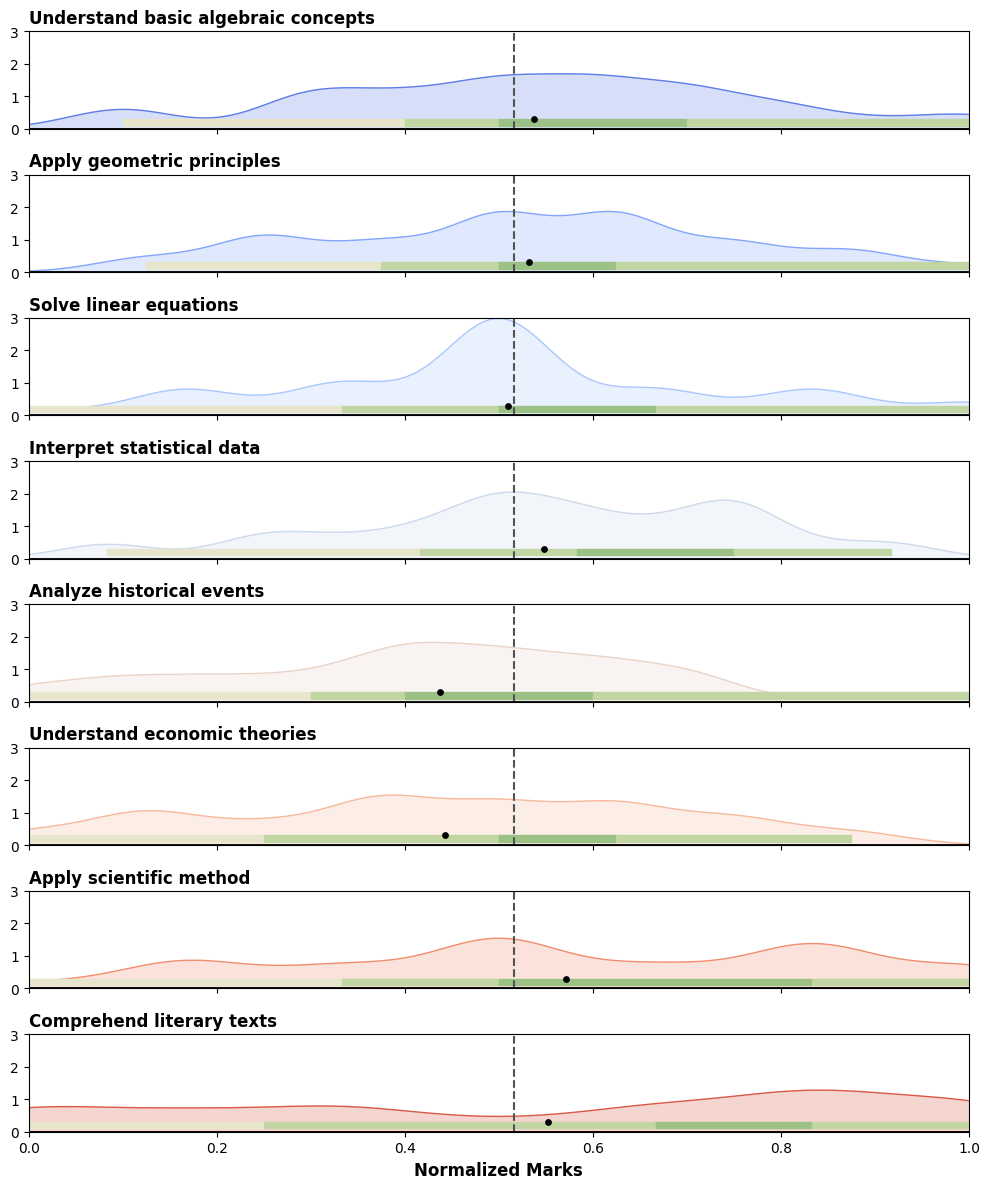

In [180]:
create_ridge_plot(pp_data)

In [74]:
pp_data

student_id learning_indicator_id  marks_obtained  maximum_marks  \
0             1                 LI001               7             10   
1             1                 LI002               5              8   
2             1                 LI003               3              6   
3             1                 LI004               8             12   
4             1                 LI005               6             10   
..          ...                   ...             ...            ...   
275          35                 LI004               6             12   
276          35                 LI005               5             10   
277          35                 LI006               2              8   
278          35                 LI007               3              6   
279          35                 LI008               4              6   

     normalized_marks              learning_indicator_text  
0            0.700000  Understand basic algebraic concepts  
1            0.625000           Apply geometric principles  
2            0.500000               Solve linear equations  
3            0.666667           Interpret statistical data  
4            0.600000            Analyze historical events  
..                ...                                  ...  
275          0.500000           Interpret statistical data  
276          0.500000            Analyze historical events  
277          0.250000         Understand economic theories  
278          0.500000              Apply scientific method  
279          0.666667            Comprehend literary texts  

[280 rows x 6 columns]

In [75]:
ngroups = pp_data['learning_indicator_id'].nunique()    # Dynamically calculate the number of rows in the chart.

bandwidth = 1

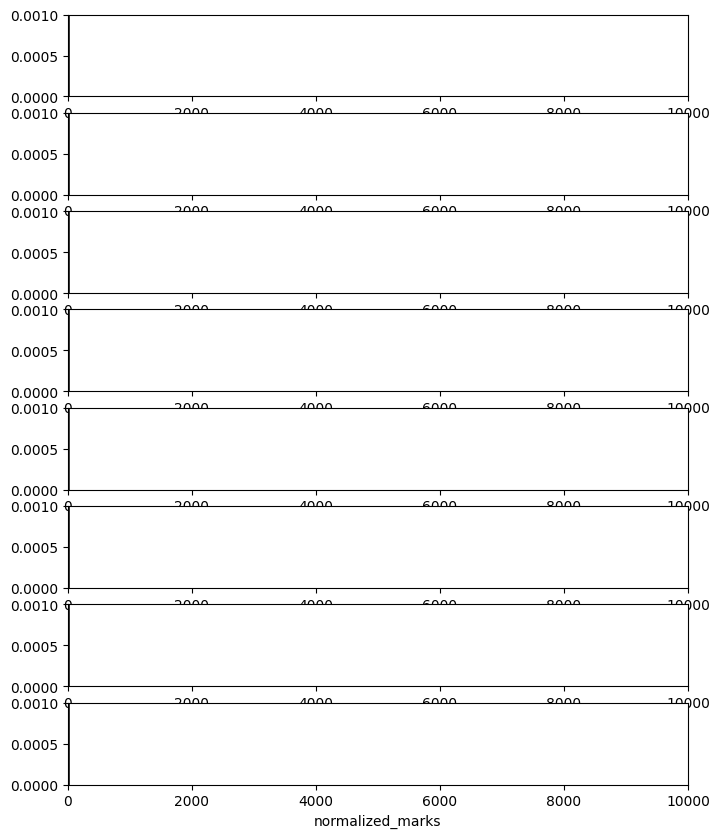

In [80]:
fig, axs = plt.subplots(nrows=ngroups, ncols=1, figsize=(8, 10))
axs = axs.flatten() # needed to access each individual axis

# iterate over axes
words = pp_data['learning_indicator_id'].unique().tolist()
for i, word in enumerate(words):

    # subset the data for each word
    subset = pp_data[pp_data['learning_indicator_id'] == word]

    # plot the distribution of prices
    sns.histplot(
        subset['normalized_marks'],
        ax=axs[i]
    )

    # set title and labels
    axs[i].set_xlim(0, 10000)
    axs[i].set_ylim(0, 0.001)
    axs[i].set_ylabel('')

plt.show()